In [38]:
# Import Libraries
import os
import cv2
from PIL import Image
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg19 import preprocess_input, VGG19


# foo = tenstorflow.keras.foo
# if foo is a submodule but not an attribute, this is (roughly) equivalent to
# import tensorflow.keras.foo as foo
# from tensorflow.keras.applications.vgg19 import preprocess_input, VGG19


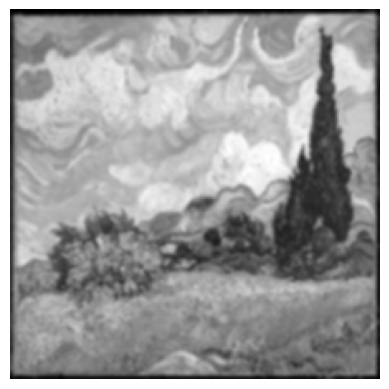

In [39]:
def preprocess_image(image_path, target_size):
    # Loading the image
    image = cv2.imread(image_path)
    
    # Resizing the image
    image = cv2.resize(image, target_size)
    
    # Normalizing the pixel values
    image = image.astype(np.float32) / 255.0
    
    # Applying noise reduction using Gaussian blur
    image = cv2.GaussianBlur(image, (5, 5), 0) # remove the blur
    
    # Converting color space to grayscale
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    return image

# Style Image 
image_path = './Style_images/van_gogh.jpg'
target_size = (224, 224)

preprocessed_image = preprocess_image(image_path, target_size)

# Display the preprocessed image
plt.imshow(preprocessed_image, cmap="gray")
plt.axis('off')  # Remove axis ticks and labels
plt.show()

# Plot in another window
# cv2.imshow("Preprocessed Image", preprocessed_image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

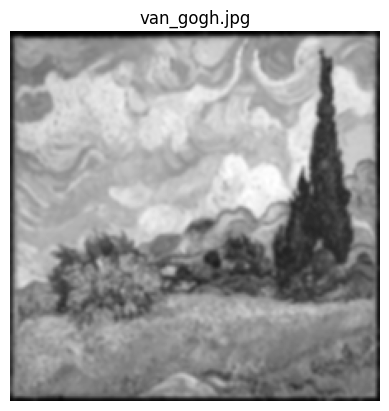

In [40]:
# Preprocess and display each image in the folder
for file_name in os.listdir('./Style_images/'):
    if file_name.endswith(('.jpg', '.jpeg', '.png')):
        image_path = os.path.join('./Style_images/', file_name)
        preprocessed_image = preprocess_image(image_path, target_size)

        plt.imshow(preprocessed_image, cmap="gray")
        plt.title(file_name)
        plt.axis('off')
        plt.show()

In [41]:
model = VGG19(include_top=False, weights='imagenet')

# Print the block names
for layer in model.layers:
    if 'block' in layer.name:
        print(layer.name)

block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [31]:
# The path to content and style images
content_image_path = './Content_images/daim building.jpeg'
style_image_path = './Style_images/van_gogh.jpg'


width, height = load_img(content_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

# Util function to open, resize and format pictures into appropriate tensors

def preprocess_data(path):
    img = load_img(
        path, target_size=(img_nrows, img_ncols)
    )
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return tf.convert_to_tensor(img)

def deprocess_image(x):
    # Util function to convert a tensor into a valid image
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

def extract_style_features(image, intermediate_layers):
    # Load the pre-trained VGG19 model
    model = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    model.trainable = False

    # Get the output tensors of the intermediate layers
    outputs = [model.get_layer(layer_name).output for layer_name in intermediate_layers]

    # Create a new model that takes the input image and outputs the style features
    style_model = tf.keras.Model(inputs=model.input, outputs=outputs)

    # Preprocess the image
    preprocessed_image = preprocess_input(image)

    # Extract the style features
    style_features = style_model(np.expand_dims(preprocessed_image, axis=0) * 255)

    return style_features

""" The keras method of preprocessing images"""
style_image = preprocess_data(style_image_path)
content_image = preprocess_data(content_image_path)

style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
content_layer ='block5_conv2'

# content_features = extract_style_features(content_image, intermediate_layers)
# style_features = extract_style_features(style_image, style_layers)

#Look at the statistics of each layer's output
# for name, output in zip(style_layers, style_features):
#   print(name)
#   print("  shape: ", output.numpy().shape)
#   print("  min: ", output.numpy().min())
#   print("  max: ", output.numpy().max())
#   print("  mean: ", output.numpy().mean())
#   print()


In [ ]:
# def visualize_features(features):
#     num_features = 64
#     fig, axes = plt.subplots(8, 8, figsize=(15, 15))
#     axes = axes.flatten()

#     for i in range(num_features):
#         feature = features[0, :, :, i]
#         axes[i].imshow(feature)
#         axes[i].axis('off')

#     plt.show()

# for name, ouput in zip(style_layers, style_features):
#     print (name)
#     visualize_features(output) 

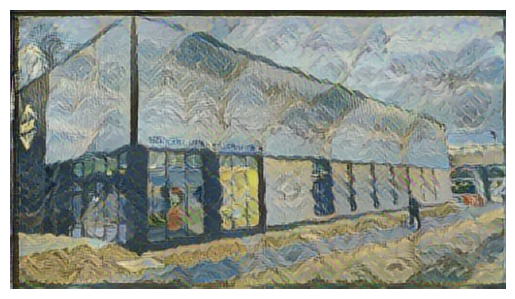

In [37]:
"""
Using Fast style transfer (tensorflow_hub)
 - This will be used as my baseline  model.
"""

# The section for Fast Style Transfer

import tensorflow_hub as hub

os.environ['tensorflowHUB_CACHE_DIR'] = "./models"
def load_image(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

def convert_tensor(tensor):
    # Scale tensor values to the range [0, 255]
    tensor = tf.clip_by_value(tensor * 255, 0, 255)

    # Remove dimensions with size 1
    tensor = tf.squeeze(tensor, axis=0)

    # Convert tensor to numpy array
    array = tensor.numpy().astype('uint8')

    # Create PIL image from numpy array
    image = Image.fromarray(array)

    return image

style_img = load_image(style_image_path)
content_img = load_image(content_image_path)

hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
"""
content_img = tensorflow.cast(content_img, dtype=tensorflow.float32)
style_img = tensorflow.cast(style_img, dtype=tensorflow.float32)

"""
stylized_image = hub_model(tf.constant(content_img), tf.constant(style_img))[0]
converted_image = convert_tensor(stylized_image)

# Plot the image
plt.imshow(converted_image)
plt.axis('off')
plt.show()

# Display the converted image as a seperate window
# converted_image.show()

# TODO:
# Try different style with the content and plot them side by side.


In [33]:
# Weights of the different loss components
total_variation_weight = 1.0
style_weight = 1e-2
content_weight = 1.0

result_name = "generated_image"

# Build a VGG19 model loaded with pre-trained ImageNet weights
model = tf.keras.applications.VGG19(weights="imagenet", include_top=False)

# Get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# Set up a model that returns the activation values for every layer in
# VGG19 (as a dict).
feature_extractor = tf.keras.Model(inputs=model.inputs, outputs=outputs_dict)

In [34]:
# The gram matrix of an image tensor (feature-wise outer product)

def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram


# The "style loss" is designed to maintain

def style_loss(style, target):
    S = gram_matrix(style)
    C = gram_matrix(target)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))


# An auxiliary loss function
# designed to maintain the "content" of the base image in the generated image


def content_loss(base, target):
    return tf.reduce_sum(tf.square(target - base))


# total variation loss,

def total_variation_loss(x):
    a = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, 1:, : img_ncols - 1, :]
    )
    b = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, : img_nrows - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))

In [35]:
def compute_loss(content_image, style_reference_image, target_image):
    input_tensor = tf.concat(
        [content_image, style_reference_image, target_image], axis=0
    )
    features = feature_extractor(input_tensor)

    # Initialize the loss
    loss = tf.zeros(shape=())

    # Add content loss
    layer_features = features[content_layer]
    content_image_features = layer_features[0, :, :, :]
    target_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        content_image_features, target_features
    )
    # Add style loss
    for layer_name in style_layers:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        target_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, target_features)
        loss += (style_weight / len(style_layers)) * sl

    # Add total variation loss
    loss += total_variation_weight * total_variation_loss(target_image)
    return loss

In [36]:
@tf.function
def compute_loss_and_gradients(content_image, style_image, target_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(content_image, style_image, target_image)
    grads = tape.gradient(loss, target_image)
    return loss, grads

In [26]:
from tqdm import tqdm
from PIL import Image

optimizer = tf.keras.optimizers.legacy.Adam(
    tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96)
)
target_image = tf.Variable(preprocess_data(content_image_path))
style_image_resized = tf.image.resize(style_image, (405, 512))

iter = 2000
for i in tqdm(range(1, iter + 1)):
    loss, grads = compute_loss_and_gradients(
        content_image, style_image, target_image,
    )
    optimizer.apply_gradients([(grads, target_image)])

    # save image after every 1000 steps
    if i % 100 == 0:
        print("Iteration %d: loss=%.2f" % (i, loss))
        img = deprocess_image(target_image.numpy())
        fname = result_name + "_at_iteration_%d.png" % i
        tf.keras.preprocessing.image.save_img(fname, img)
        # display(Image(fname))

  5%|▌         | 100/2000 [10:39<8:32:31, 16.19s/it]

Iteration 100: loss=1393525632.00


 10%|█         | 200/2000 [20:16<4:09:30,  8.32s/it]

Iteration 200: loss=1901335680.00


 15%|█▌        | 300/2000 [29:20<2:24:20,  5.09s/it]

Iteration 300: loss=2150184960.00


 20%|██        | 400/2000 [43:46<18:55:02, 42.56s/it]

Iteration 400: loss=2233924608.00


 25%|██▌       | 500/2000 [53:03<2:00:15,  4.81s/it] 

Iteration 500: loss=2351400960.00


 30%|███       | 600/2000 [1:00:58<1:51:36,  4.78s/it]

Iteration 600: loss=2334441728.00


 35%|███▌      | 700/2000 [1:09:02<1:46:38,  4.92s/it]

Iteration 700: loss=2375010816.00


 40%|████      | 800/2000 [1:16:53<1:34:37,  4.73s/it]

Iteration 800: loss=2321303040.00


 45%|████▌     | 900/2000 [1:24:54<1:30:19,  4.93s/it]

Iteration 900: loss=2313457408.00


 50%|█████     | 1000/2000 [1:34:48<1:25:42,  5.14s/it]

Iteration 1000: loss=2279677184.00


 55%|█████▌    | 1100/2000 [1:42:45<1:10:42,  4.71s/it]

Iteration 1100: loss=2170806272.00


 60%|██████    | 1200/2000 [1:52:04<3:02:07, 13.66s/it]

Iteration 1200: loss=2055017600.00


 65%|██████▌   | 1300/2000 [2:00:50<58:30,  5.01s/it]  

Iteration 1300: loss=1964378112.00


 70%|███████   | 1400/2000 [2:09:09<48:59,  4.90s/it]  

Iteration 1400: loss=2010891008.00


 75%|███████▌  | 1500/2000 [2:18:43<4:16:18, 30.76s/it]

Iteration 1500: loss=1964421632.00


 80%|████████  | 1600/2000 [2:27:09<32:09,  4.82s/it]  

Iteration 1600: loss=1989040768.00


 85%|████████▌ | 1700/2000 [2:35:08<23:48,  4.76s/it]

Iteration 1700: loss=1858649728.00


 90%|█████████ | 1800/2000 [2:43:28<16:34,  4.97s/it]

Iteration 1800: loss=1720663424.00


 95%|█████████▌| 1900/2000 [2:55:40<07:46,  4.67s/it]  

Iteration 1900: loss=1707422080.00


100%|██████████| 2000/2000 [3:04:00<00:00,  5.52s/it]

Iteration 2000: loss=1746182784.00


In [ ]:
# TODO: 
# 1. apply spatial smooting, genera
# 2. generated the loss graph
# 3. Evaluate the style trasfer process.  
